# EV Charging Network Challenge

## Problem Statement 
`To optimally place EV charging stations, so that the configuration remains robust to demographic changes.`

##### Notations and Constants
* 𝑖 = Index of the demand point. 𝑖 varies from 0 to 4095
* 𝑗 = Index of the supply point (parking location). 𝑗𝑗 varies from 0 to 99
* 𝐷𝑖 = EV charging demand at 𝑖𝑡ℎ demand point.
* 𝑆CS𝑗 = Number of slow charging stations at 𝑗𝑡ℎ supply point
* 𝐹CS𝑗 = Number of fast charging stations at 𝑗𝑡ℎ supply point
* 𝑃S𝑗 = Total parking slots available at 𝑗𝑡ℎ supply point
* 𝐶apscs = Charging capacity of a slow charging station = 20
* 𝐶apfcs = Charging capacity of a slow charging station = 400
* 𝑆max𝑗 = Maximum supply that can be given from 𝑗𝑡ℎ supply point = (𝐶apscs × 𝑆CS𝑗) + (𝐶apfcs × FCS𝑗)
* 𝐷ist𝑖j = Distance between 𝑖𝑡ℎ demand point and 𝑗𝑡ℎ supply point (Distance matrix)
* 𝐷S𝑖j = How much demand of the 𝑖𝑡ℎ demand point is satisfied by the 𝑗𝑡ℎ supply point (Demand-Supply matrix)

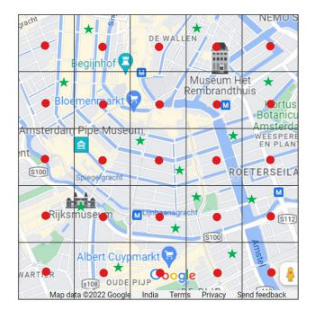

In [23]:
figure(figsize=(5, 5), dpi=80)
img = mpimg.imread('Capture.jpg')
plt.axis('off')
plt.imshow(img)

## Approach

* Train-Test split: Trainng - 2010-2017 & Testing - 2018 
* Create baseline model using moving average 
* Use linear regression, random forest and other tree based regression algorithms to ascertain EV Charging demand 
* 

In [39]:
#setting up W&B for Experiemnt tracking
#!pip install --upgrade -q wandb
import wandb
from wandb.keras import WandbCallback

wandb.login(key='0108020bf5d0a6642b207fc7ebc81bdfef3f89d3')
wandb.login()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\DELL/.netrc


True

In [1]:
#Importing libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
#import plotly.graph_objects as go
#!pip install category_encoders
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import wandb
import os

In [2]:
#reading the data
demand = pd.read_csv('Demand_History.csv')
supply = pd.read_csv('exisiting_EV_infrastructure_2018.csv')

#Data quality checks done
* No null values 
* data type as float for all numerical features

## Feature Engineering and EDA

##### Highlights
* Strong autocorrelation observed
* High multicollinearity
* Different, inconsitent data distribution observed, which makes generalisation a challenge
* For each grid, EV demand follows a similar pattern every year
* No outliers
* Derived Features i) YoY growth rates have been determined ii) Avg. growth rate has been derived
* Grid clusters will be created using kmeans followed by creating a categorical feature 

In [3]:
demand.head()

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563


In [4]:
#transposing the demand DF 
demand1=demand.transpose()

In [5]:
demand_t = demand1.iloc[3: , :]
demand_t

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
2010,0.352242,0.325940,0.373752,0.420686,0.475621,0.380156,0.449348,0.470071,0.537307,0.445734,...,0.114351,0.075160,0.081059,0.083821,0.158356,0.171015,0.041716,0.100895,0.155353,0.209372
2011,0.667932,0.591964,0.591890,0.584055,0.647940,0.725189,0.730466,0.866474,0.833661,0.775279,...,0.185420,0.131877,0.138802,0.158354,0.376271,0.334565,0.061741,0.180352,0.290825,0.340185
2012,0.958593,0.862652,0.969733,0.906547,0.981544,1.076054,1.220484,1.615454,1.622691,1.316209,...,0.489806,0.298811,0.227962,0.393987,0.670141,0.556055,0.131291,0.296299,0.557803,0.749491
2013,2.911901,2.589068,2.641432,2.378577,2.665400,2.762618,2.655187,3.273061,3.366533,3.795858,...,1.285151,0.819191,0.604009,0.966916,1.584710,1.373291,0.386540,0.705373,1.516066,1.904285
2014,4.338274,4.196034,3.541772,3.888121,4.218711,4.220747,5.333594,5.442867,5.973267,4.781361,...,2.168647,1.086649,1.012104,1.703340,2.272350,1.837586,0.755846,1.300220,2.399426,2.775772
2015,6.561995,5.745551,5.469161,5.846089,6.776609,6.760395,8.620496,8.681284,10.033183,9.277640,...,3.320948,1.427004,1.158568,2.083558,3.635703,2.517146,0.941116,1.608609,2.719197,3.404641
2016,8.454417,8.753195,8.414627,9.083868,8.851107,9.331196,11.406751,11.135352,13.210567,10.992479,...,4.336336,1.924844,1.350226,2.802044,5.880033,3.352280,1.107797,1.822806,4.494515,4.574922
2017,10.595324,11.126995,10.115336,12.424885,11.731131,14.743943,13.115854,14.708272,17.291626,17.386210,...,6.095297,2.054926,1.598313,3.284002,7.672174,4.149888,1.309479,2.333681,6.096858,6.301078
2018,13.119572,12.020091,14.018254,15.012302,16.355563,17.559998,19.696415,19.367417,21.899847,21.765241,...,6.625857,3.612612,2.643128,4.127373,7.833432,5.426193,2.057450,3.218519,6.262574,6.860939


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

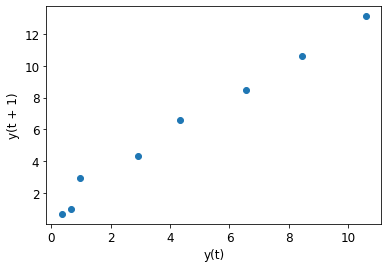

In [6]:
#checking autocorrelation
plt.rcParams.update({'font.size': 12})
df=demand_t[0]
pd.plotting.lag_plot(df, lag=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

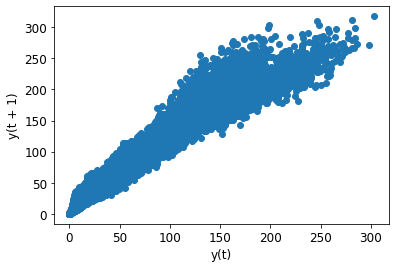

In [7]:
pd.plotting.lag_plot(demand_t, lag=1)

In [8]:
#Describing the demand data 
demand.describe()

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018
count,4096.00000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000
mean,2047.50000,32.000000,32.000000,1.993306,4.017967,7.552549,19.323394,31.891712,42.249471,58.718724,75.805574,88.264071
std,1182.55768,18.475209,18.475209,1.849883,4.003144,7.658317,19.080365,31.270080,39.501338,56.133565,76.390728,79.513884
min,0.00000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1023.75000,16.250000,16.250000,0.474756,0.898346,1.613829,4.480010,6.958344,10.634926,15.245858,22.668290,25.275349
50%,2047.50000,32.000000,32.000000,1.163430,2.134510,3.854949,10.045907,17.872258,24.146146,31.755415,37.285351,54.567937
75%,3071.25000,47.750000,47.750000,3.665382,6.996849,13.579687,34.418367,56.016385,77.892036,108.528007,138.112588,158.637564
max,4095.00000,63.500000,63.500000,6.641083,14.961144,28.383260,70.789208,117.063595,148.491476,219.652855,302.729826,317.422418


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

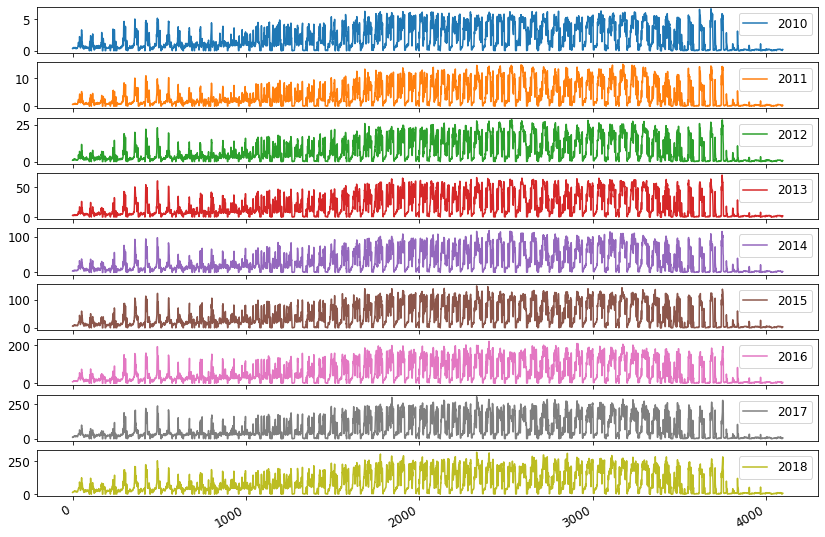

In [9]:
demand_vis = demand[['2010','2011','2012','2013','2014','2015','2016','2017','2018']]
demand_vis.plot(subplots=True, figsize=(14, 10))

In [10]:
demand_vis.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572
1,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091
2,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254
3,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302
4,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563


array([[<AxesSubplot:title={'center':'2010'}>,
        <AxesSubplot:title={'center':'2011'}>,
        <AxesSubplot:title={'center':'2012'}>],
       [<AxesSubplot:title={'center':'2013'}>,
        <AxesSubplot:title={'center':'2014'}>,
        <AxesSubplot:title={'center':'2015'}>],
       [<AxesSubplot:title={'center':'2016'}>,
        <AxesSubplot:title={'center':'2017'}>,
        <AxesSubplot:title={'center':'2018'}>]], dtype=object)

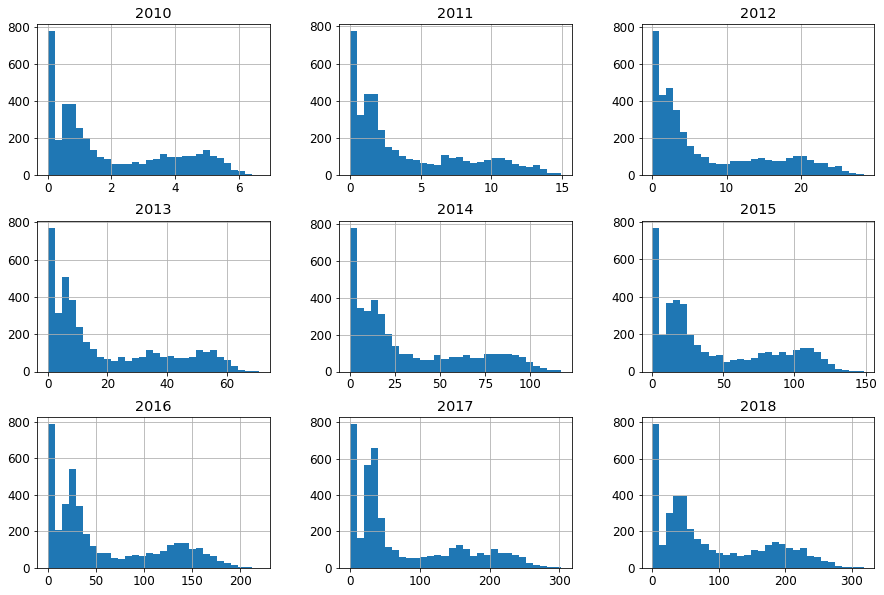

In [11]:
#Univariate analysis
demand_vis.hist(bins=30, figsize=(15, 10))

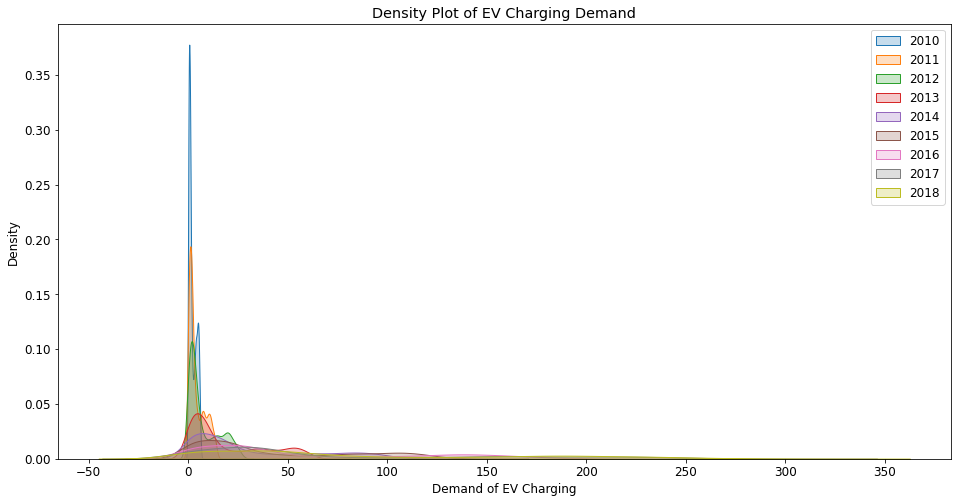

In [12]:
#checking probability density for each year
plt.figure(figsize=(16,8))
ax = sns.kdeplot(demand_vis["2010"], shade=True)
sns.kdeplot(demand_vis["2011"], shade=True)
sns.kdeplot(demand_vis["2012"], shade=True)
sns.kdeplot(demand_vis["2013"], shade=True)
sns.kdeplot(demand_vis["2014"], shade=True)
sns.kdeplot(demand_vis["2015"], shade=True)
sns.kdeplot(demand_vis["2016"], shade=True)
sns.kdeplot(demand_vis["2017"], shade=True)
sns.kdeplot(demand_vis["2018"], shade=True)
plt.legend(['2010', '2011', '2012', '2013','2014','2015', '2016','2017','2018'])
plt.title('Density Plot of EV Charging Demand')
ax.set(xlabel= 'Demand of EV Charging')
ax.set(ylabel='Density')
plt.grid(False)
plt.show()

<AxesSubplot:>

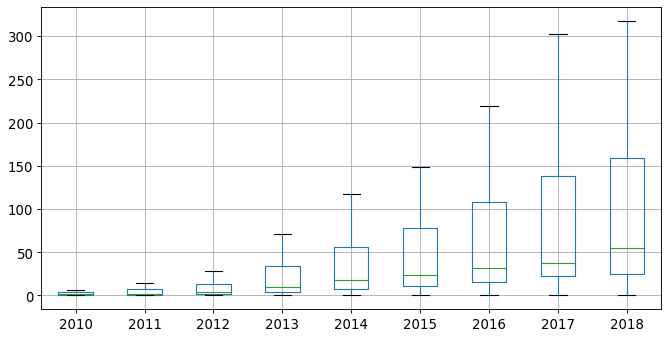

In [13]:
figure(figsize=(10, 5), dpi=80)
demand_vis.boxplot()

In [14]:
#creating new features-YoY growth in EV demand & avg. growth rate  
demand_growth = demand[['2010','2011','2012','2013','2014','2015','2016','2017','2018']]
demand_growth['delta_11_10'] = (demand_growth['2011'] - demand_growth['2010']) 
demand_growth['delta_12_11'] = ((demand_growth['2012'] - demand_growth['2011']))
demand_growth['delta_13_12'] = ((demand_growth['2013'] - demand_growth['2012']))
demand_growth['delta_14_13'] = ((demand_growth['2014'] - demand_growth['2013']))
demand_growth['delta_15_14'] = ((demand_growth['2015'] - demand_growth['2014']))
demand_growth['delta_16_15'] = ((demand_growth['2016'] - demand_growth['2015']))
demand_growth['delta_17_16'] = ((demand_growth['2017'] - demand_growth['2016'])) 
demand_growth['delta_18_17'] = ((demand_growth['2018'] - demand_growth['2017']))
#demand_growth['growth_11_10'] = ((demand_growth['2011'] - demand_growth['2010'])/demand_growth['2010'])*100
#demand_growth['growth_12_11'] = (((demand_growth['2012'] - demand_growth['2011']))/demand_growth['2011'])*100
#demand_growth['growth_13_12'] = (((demand_growth['2013'] - demand_growth['2012']))/demand_growth['2012'])*100
#demand_growth['growth_14_13'] = (((demand_growth['2014'] - demand_growth['2013']))/demand_growth['2013'])*100
#demand_growth['growth_15_14'] = (((demand_growth['2015'] - demand_growth['2014']))/demand_growth['2014'])*100
#demand_growth['growth_16_15'] = (((demand_growth['2016'] - demand_growth['2015']))/demand_growth['2015'])*100
#demand_growth['growth_17_16'] = (((demand_growth['2017'] - demand_growth['2016']))/demand_growth['2016'])*100
#demand_growth['growth_18_17'] = (((demand_growth['2018'] - demand_growth['2017']))/demand_growth['2017'])*100
demand_growth['avg_delta'] = (demand_growth['delta_11_10']+demand_growth['delta_12_11']+demand_growth['delta_13_12']+demand_growth['delta_14_13']+demand_growth['delta_15_14']+demand_growth['delta_16_15']+demand_growth['delta_17_16']+demand_growth['delta_18_17'])/8

<ipython-input-14-5784b50ee36e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_growth['delta_11_10'] = (demand_growth['2011'] - demand_growth['2010'])
<ipython-input-14-5784b50ee36e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_growth['delta_12_11'] = ((demand_growth['2012'] - demand_growth['2011']))


In [15]:
#demand_growth['growth_18_10'].describe()
#demand_growth.describe()
demand_growth.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,delta_11_10,delta_12_11,delta_13_12,delta_14_13,delta_15_14,delta_16_15,delta_17_16,delta_18_17,avg_delta
0,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,0.315690,0.290662,1.953307,1.426374,2.223720,1.892423,2.140907,2.524248,1.595916
1,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,0.266024,0.270688,1.726416,1.606966,1.549517,3.007644,2.373800,0.893096,1.461769
2,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,0.218138,0.377843,1.671699,0.900340,1.927388,2.945466,1.700709,3.902918,1.705563
3,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,0.163368,0.322492,1.472030,1.509544,1.957968,3.237779,3.341017,2.587417,1.823952
4,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,0.172319,0.333604,1.683855,1.553311,2.557898,2.074498,2.880024,4.624432,1.984993


<AxesSubplot:>

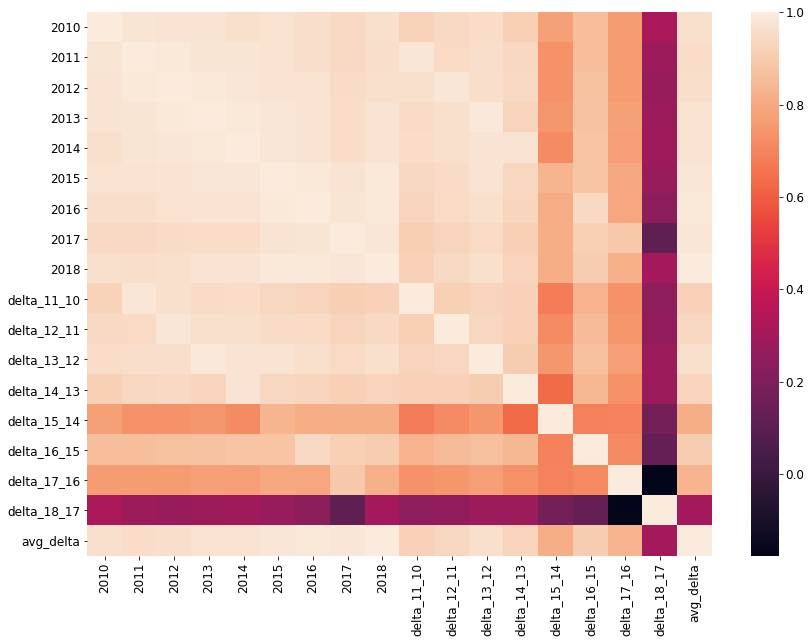

In [16]:
figure(figsize=(14,10))
sns.heatmap(demand_growth.corr())

In [17]:
pd.set_option('display.max_columns', None)
demand_growth.corr()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,delta_11_10,delta_12_11,delta_13_12,delta_14_13,delta_15_14,delta_16_15,delta_17_16,delta_18_17,avg_delta
2010,1.000000,0.977204,0.972708,0.972828,0.967110,0.971257,0.961096,0.943880,0.965881,0.924550,0.940471,0.958281,0.917140,0.771451,0.858062,0.761312,0.316550,0.964266
2011,0.977204,1.000000,0.987160,0.979859,0.979022,0.970986,0.961116,0.944142,0.959752,0.984374,0.945635,0.960306,0.935853,0.735068,0.858713,0.762106,0.282356,0.958539
2012,0.972708,0.987160,1.000000,0.986268,0.984964,0.976001,0.968019,0.950224,0.963820,0.965057,0.985444,0.962372,0.940841,0.736233,0.869141,0.765342,0.272843,0.962807
2013,0.972828,0.979859,0.986268,1.000000,0.988612,0.982763,0.974765,0.958003,0.972783,0.951853,0.965255,0.994034,0.929226,0.750762,0.875285,0.774380,0.280830,0.971974
2014,0.967110,0.979022,0.984964,0.988612,1.000000,0.982532,0.975358,0.957009,0.972756,0.955092,0.963490,0.976159,0.974250,0.716083,0.877621,0.769799,0.285802,0.972082
2015,0.971257,0.970986,0.976001,0.982763,0.982532,1.000000,0.988001,0.974042,0.986506,0.937230,0.953793,0.972453,0.940122,0.833471,0.878704,0.794602,0.271795,0.986049
2016,0.961096,0.961116,0.968019,0.974765,0.975358,0.988001,1.000000,0.981547,0.986849,0.927941,0.948046,0.964565,0.934491,0.809764,0.941889,0.790399,0.234995,0.986641
2017,0.943880,0.944142,0.950224,0.958003,0.957009,0.974042,0.981547,1.000000,0.982677,0.911755,0.929881,0.948737,0.914548,0.811888,0.915215,0.892955,0.117646,0.982784
2018,0.965881,0.959752,0.963820,0.972783,0.972756,0.986506,0.986849,0.982677,1.000000,0.921524,0.940949,0.964078,0.931070,0.811883,0.904492,0.824979,0.299647,0.999981
delta_11_10,0.924550,0.984374,0.965057,0.951853,0.955092,0.937230,0.927941,0.911755,0.921524,1.000000,0.917263,0.928823,0.919055,0.679505,0.829597,0.736447,0.244244,0.920687


In [18]:
#checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
X=demand_vis
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,67.047538,2010
1,104.025414,2011
2,129.588317,2012
3,135.064575,2013
4,129.636694,2014
5,165.350373,2015
6,137.864891,2016
7,67.522505,2017
8,136.375843,2018


## Data preparation for Modeling 

###### Identifying Categorical and numerical features 


In [19]:
cat_features = []

In [33]:
demand_clusters=demand_growth

In [34]:
demand_growth.columns

Index(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       'delta_11_10', 'delta_12_11', 'delta_13_12', 'delta_14_13',
       'delta_15_14', 'delta_16_15', 'delta_17_16', 'delta_18_17',
       'avg_delta'],
      dtype='object')

In [35]:
x_columns = [ '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       'delta_11_10', 'delta_12_11', 'delta_13_12', 'delta_14_13',
       'delta_15_14', 'delta_16_15', 'delta_17_16',  'avg_delta']

In [36]:
num_features = list(set(x_columns) - set(cat_features))

In [37]:
demand_clusters = demand_clusters[x_columns + ['2018']].dropna()

In [38]:
def prepare_data(X,
                 y,
#                 num_scaler = None,
#                 num_imputer = None,
#                 cat_imputer = None,
                 cat_encoder,
                 num_features,
                 cat_features,
                 train_size = 0.8,
                 seed = 100):
  
  # Split the dataset into train and test split
  x_train, x_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      train_size = train_size,
                                                      random_state = seed)
  
  
  # encoder the categorical features
  cat_encoder.fit(X=x_train, y=y_train)
  x_train_encoded = cat_encoder.transform(x_train)
  x_test_encoded = cat_encoder.transform(x_test)

  return x_train_encoded, x_test_encoded, y_train, y_test

###### Initializing W&B

In [39]:
os.environ["WANDB_API_KEY"] = "0108020bf5d0a6642b207fc7ebc81bdfef3f89d3"

In [40]:
def run_model_experiment(model,
                         x_train,
                         y_train,
                         x_test,
                         y_test,
                         name,
                         config = None,
                         tags = None):
  
  model.fit(x_train, y_train)

  wandb.init(project='ev_charging', config=config, tags = tags)
  wandb.run.name = name
  rmse = np.sqrt(mean_squared_error(y_test, model.predict(x_test)))
  r2 = model.score(x_test, y_test)

  wandb.log( {"rmse" : rmse, 
              "r2": r2} )
  
  wandb.sklearn.plot_regressor(model, 
                               x_train, 
                               x_test, 
                               y_train, 
                               y_test,  
                               model_name=name)
  
  wandb.Artifact(name, 
                 type = 'model',
                 description = config)

  wandb.save()
  wandb.finish()

  return model

## Creating a baseline model - Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [42]:
demand_lr = demand_clusters [['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018','avg_delta']]
#demand_lr['avg_last3yrs'] = (demand_lr['2017']+demand_lr['2016']+demand_lr['2015'])/3
#demand_lr.head()

In [43]:
X = demand_lr[['avg_delta','2017','2016', '2015','2014', '2013','2012','2011']]
y = demand_lr[['2018']]

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=101)

In [45]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape) 
print(y_test.shape)

(3276, 8)
(820, 8)
(3276, 1)
(820, 1)


In [46]:
import statsmodels.api as sm
Reg1 = sm.OLS(y_train, sm.add_constant(X_train)).fit()
Reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   2018   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.320e+07
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        21:00:03   Log-Likelihood:                -1033.0
No. Observations:                3276   AIC:                             2084.
Df Residuals:                    3267   BIC:                             2139.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0627      0.009      6.660      0.000       0.044       0.081
avg_delta      8.0663      0.005   1751.725      0.000       8.057       8.075
2017          -0.0042      0.000     -9.234      0.000      -0.005      -0.003
2016          -0.0011      0.001     -1.242      0.214      -0.003       0.001
2015           0.0116      0.001      8.996      0.000       0.009       0.014
2014          -0.0137      0.001     -9.185      0.000      -0.017      -0.011
2013           0.0188      0.002      7.582      0.000       0.014       0.024
2012           0.0182      0.006      2.948      0.003       0.006       0.030
2011           0.2604      0.010     27.203      0.000       0.242       0.279
==============================================================================
Omnibus:                      244.318   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1185.813
Skew:                          -0.160   Prob(JB):                    3.19e-258
Kurtosis:                       5.930   Cond. No.                         281.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
lreg_v1 = LinearRegression()
lreg_v1.fit( X_train, y_train )

y_pred_v1 = lreg_v1.predict(X_test)

In [48]:
lreg_v1.intercept_

array([0.06268764])

In [49]:
lreg_v1.coef_

array([[ 8.06626586e+00, -4.19529188e-03, -1.05841582e-03,
         1.16322573e-02, -1.36654783e-02,  1.87562194e-02,
         1.81544817e-02,  2.60393099e-01]])

In [50]:
y_pred_v1 = lreg_v1.predict(X_test)

In [51]:
y_pred_v1.shape

(820, 1)

In [52]:
predicted = pd.DataFrame(y_pred_v1)
actual = pd.DataFrame(y_test)


In [53]:
residual = actual - predicted 

In [54]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error( actual, predicted ))

0.34342041866405537

In [55]:
actual.to_csv('D:/Harjot/Python/Jupyter/Shell/actual.csv')  
predicted.to_csv('D:/Harjot/Python/Jupyter/Shell/predicted.csv')  

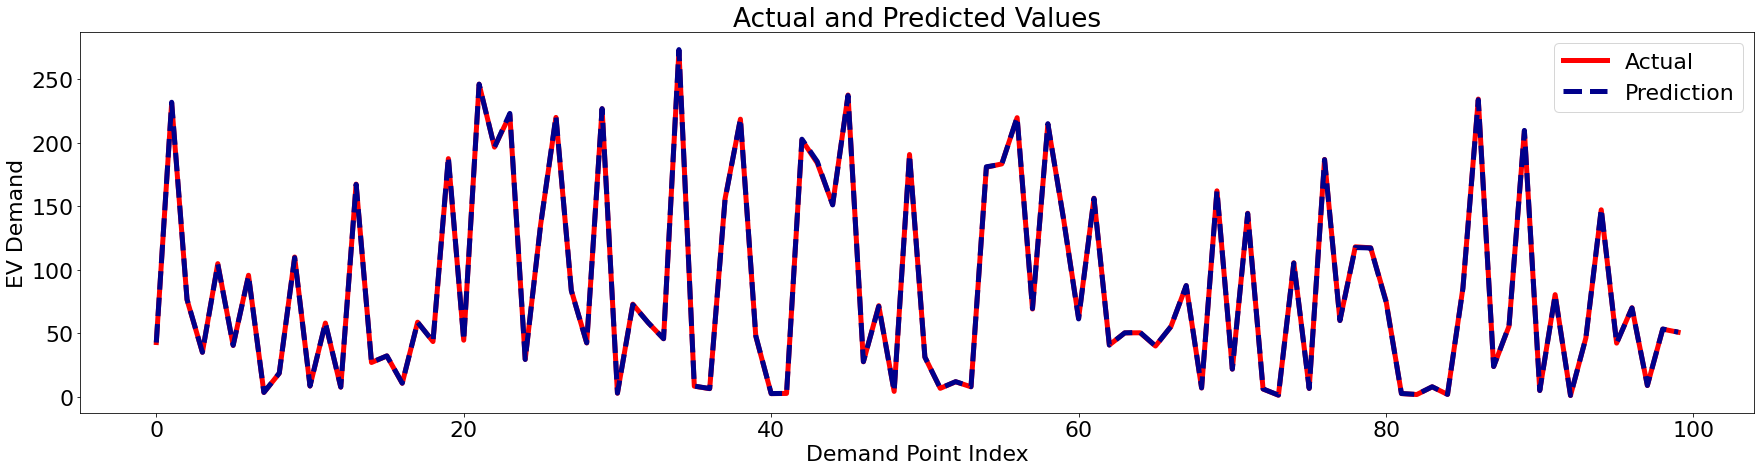

In [56]:
#actuals = pd.DataFrame(y_test_npf)
#pred = pd.DataFrame(predictions)
#pred=pred.rename(columns={0:'ACTUAL_POOL_PRICE'})

predicted.reset_index(level=0, inplace=True)
actual.reset_index(level=0, inplace=True)

predicted=predicted.drop(['index'],axis=1)
actual=actual.drop(['index'],axis=1)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,7))
plt.plot(actual['2018'][:100], c='red',linewidth=5, label="Actual") 
plt.plot(predicted[0][:100], c='darkblue', linestyle ='dashed',linewidth=5, label="Prediction")
plt.legend(loc="upper right")

# Graph labels
plt.xlabel('Demand Point Index'); plt.ylabel('EV Demand'); plt.title('Actual and Predicted Values');

In [57]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print(f'Coefficients: {lin_reg.coef_}')
print(f'Intercept: {lin_reg.intercept_}')
print(f'R^2 score: {lin_reg.score(X_train, y_train)}')

Coefficients: [[ 8.06626586e+00 -4.19529188e-03 -1.05841582e-03  1.16322573e-02
  -1.36654783e-02  1.87562194e-02  1.81544817e-02  2.60393099e-01]]
Intercept: [0.06268764]
R^2 score: 0.999982396531279


In [58]:
import statsmodels.api as sm

X_constant = sm.add_constant(X_train)
lin_reg = sm.OLS(y_train,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   2018   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.320e+07
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        21:00:24   Log-Likelihood:                -1033.0
No. Observations:                3276   AIC:                             2084.
Df Residuals:                    3267   BIC:                             2139.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0627      0.009      6.660      0.000       0.044       0.081
avg_delta      8.0663      0.005   1751.725      0.000       8.057       8.075
2017          -0.0042      0.000     -9.234      0.000      -0.005      -0.003
2016          -0.0011      0.001     -1.242      0.214      -0.003       0.001
2015           0.0116      0.001      8.996      0.000       0.009       0.014
2014          -0.0137      0.001     -9.185      0.000      -0.017      -0.011
2013           0.0188      0.002      7.582      0.000       0.014       0.024
2012           0.0182      0.006      2.948      0.003       0.006       0.030
2011           0.2604      0.010     27.203      0.000       0.242       0.279
==============================================================================
Omnibus:                      244.318   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1185.813
Skew:                          -0.160   Prob(JB):                    3.19e-258
Kurtosis:                       5.930   Cond. No.                         281.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

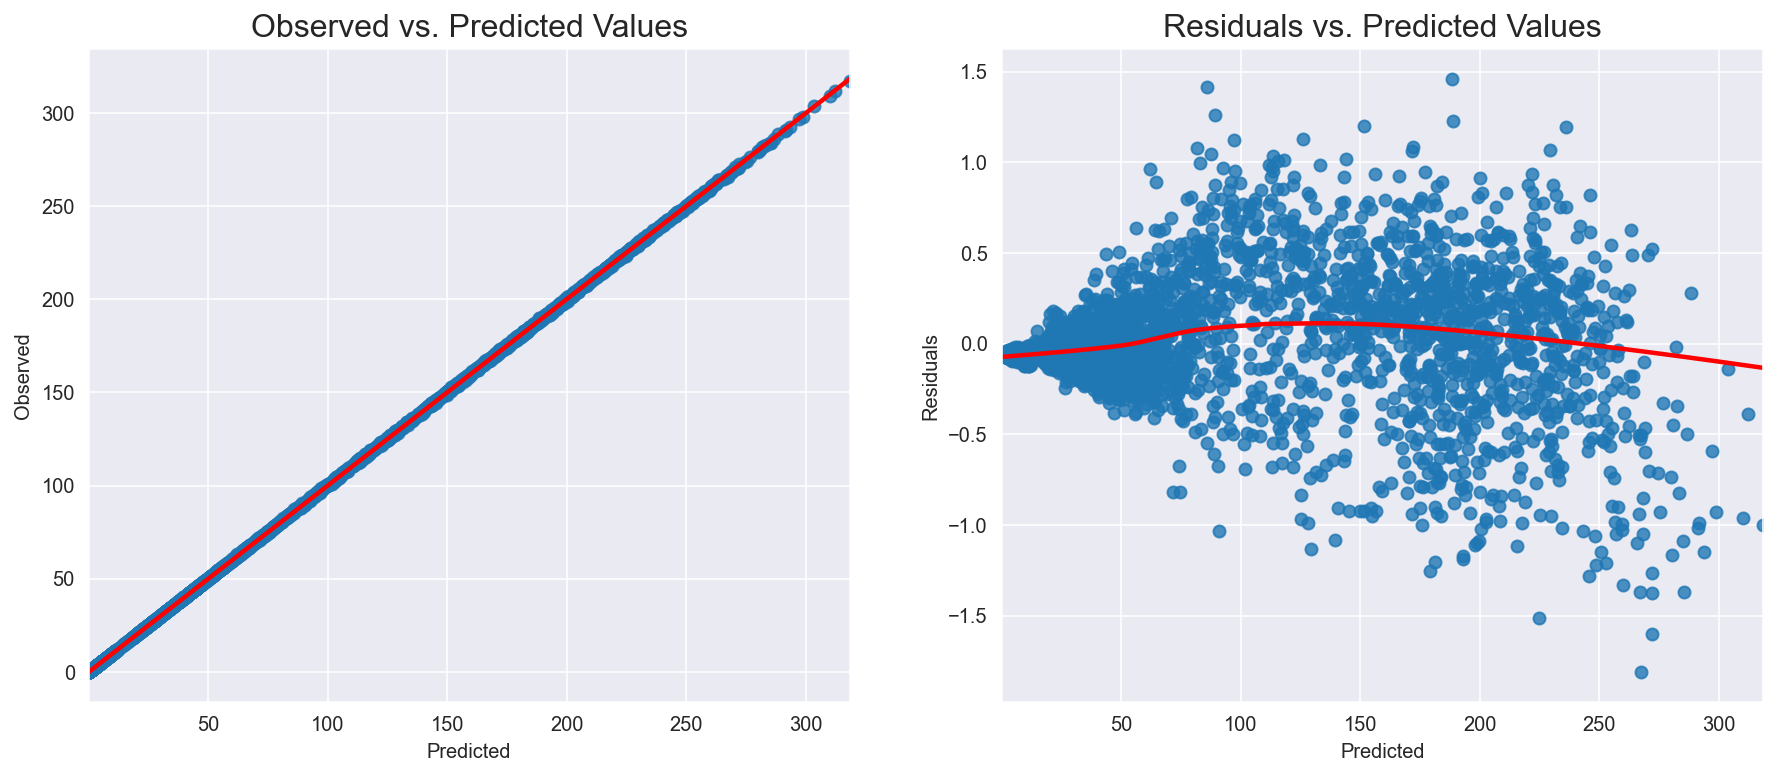

In [67]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 6.0)

def linearity_test(model, y):
     '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
   
fitted_vals = lin_reg.predict()
resids = lin_reg.resid

fig, ax = plt.subplots(1,2)
    
sns.regplot(x=fitted_vals, y=y_train, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(lin_reg, y_train)    

In [68]:
lin_reg.resid.mean()

-5.0296085299590624e-14

In [69]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

,avg_delta,2017,2016,2015,2014,2013,2012,2011
vif,58.753258,35.473392,67.33416,76.62073,63.242335,65.183787,65.302537,42.858494



 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   7.761923e+02
p-value                        2.779777e-162
f-value                         1.268008e+02
f p-value                      1.430303e-185

 Goldfeld-Quandt test ----
                value
F statistic  1.000292
p-value      0.497649

 Residuals plots ----


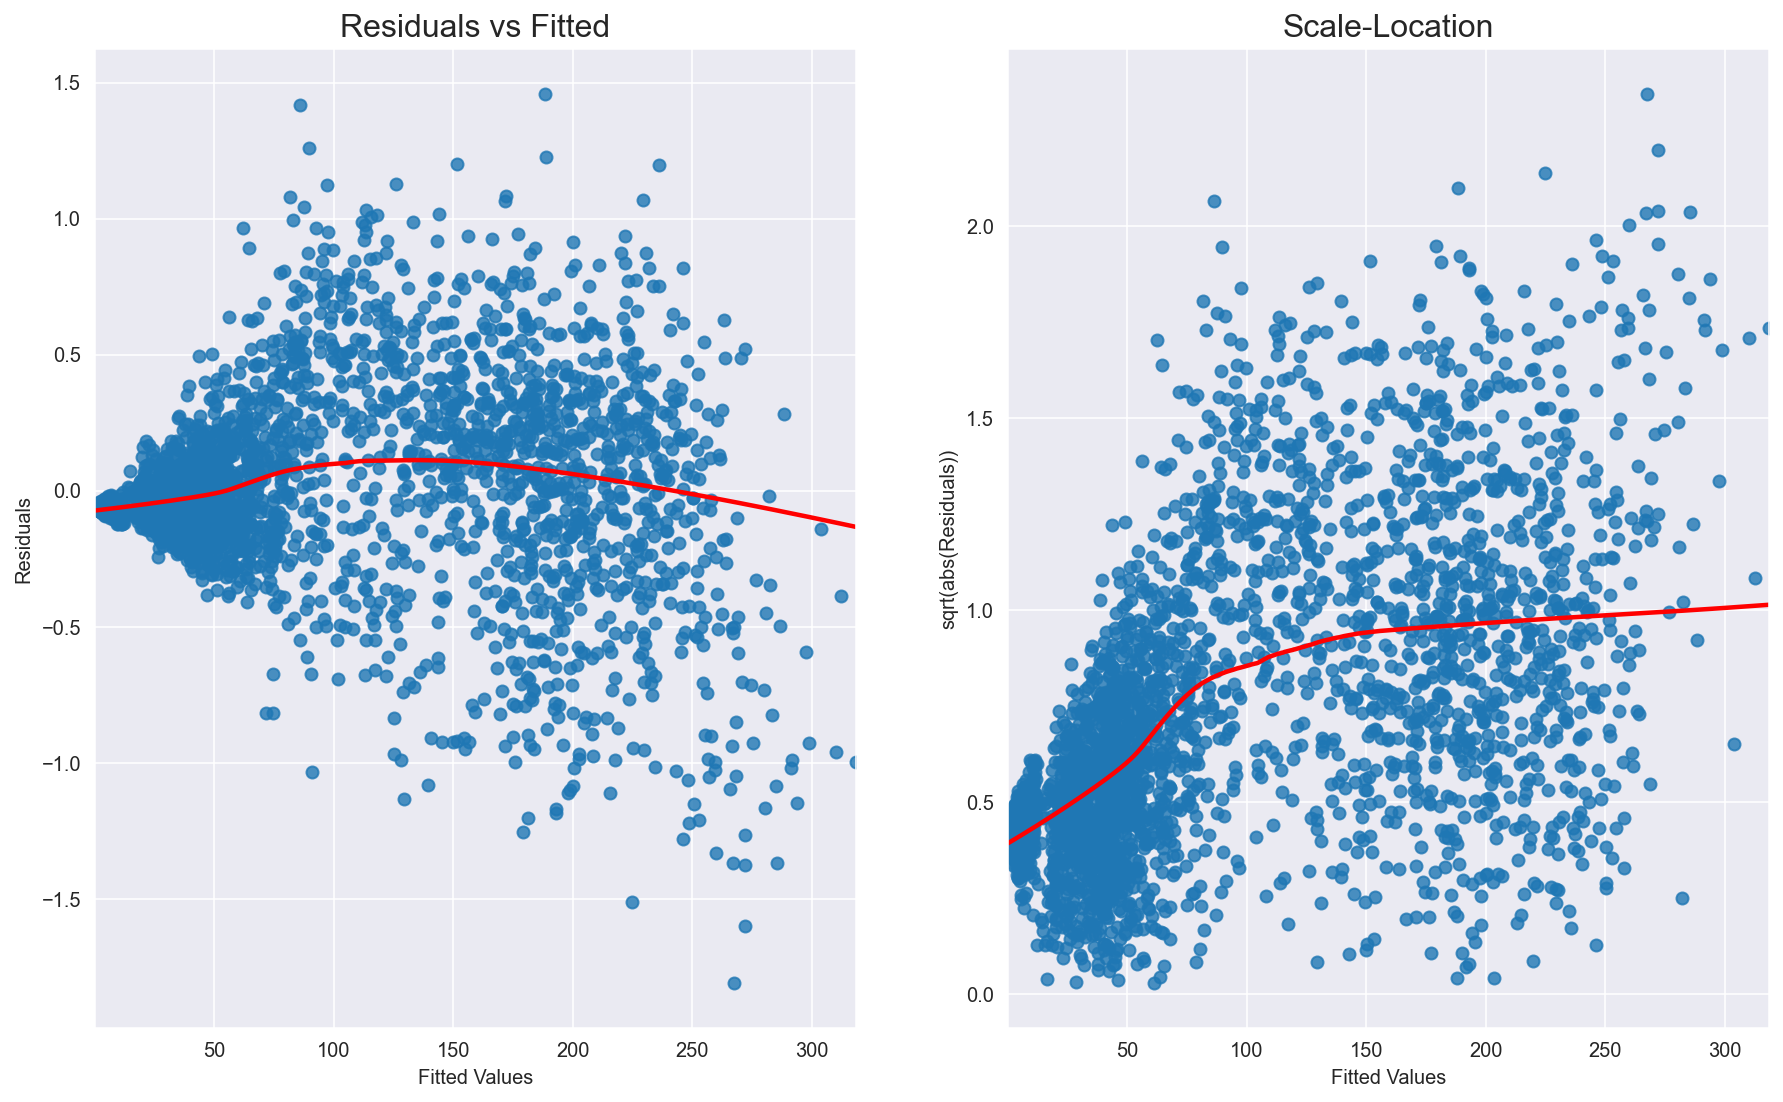

In [70]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(lin_reg)

<ipython-input-71-1dd21ae0b56e>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


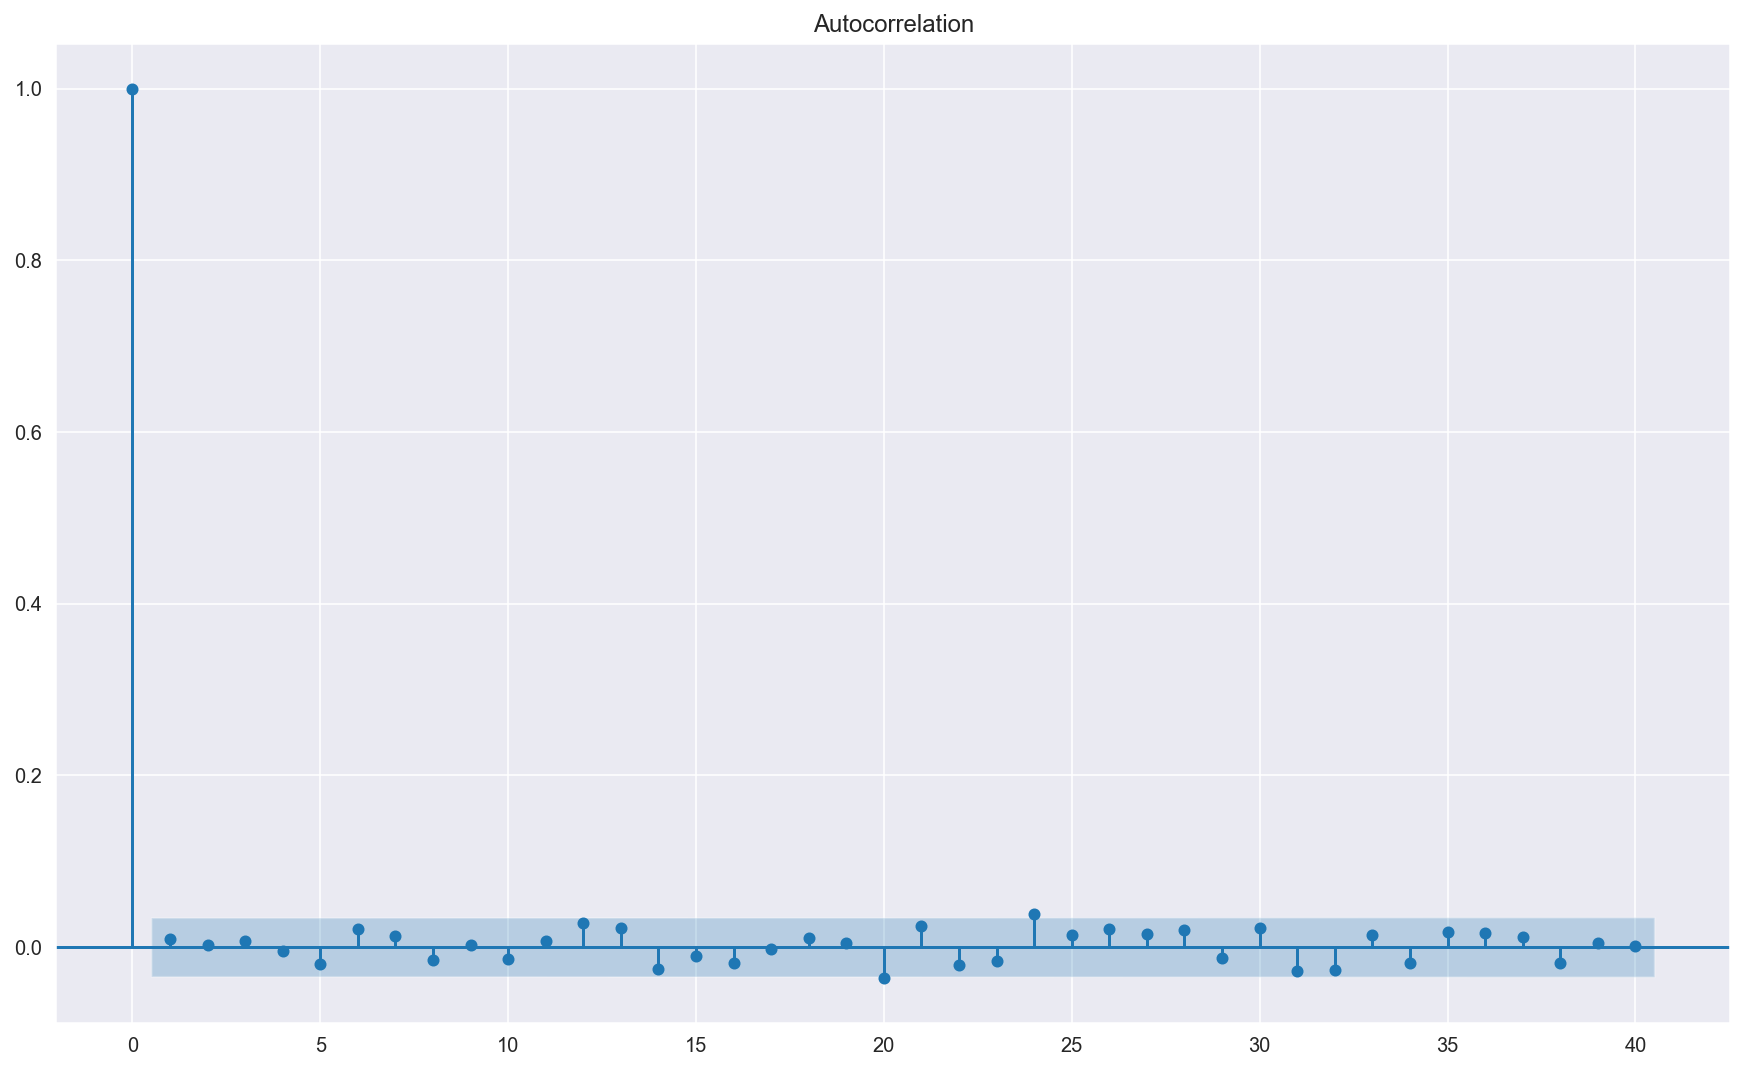

In [71]:
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(lin_reg.resid, lags=40 , alpha=0.05)
acf.show()

# Predictions 2019 and 2020

In [73]:
df_2019=pd.read_csv('Test_data_2019.csv')

In [77]:
y_pred_2019 = lreg_v1.predict(df_2019)

In [84]:
pred_2019=pd.DataFrame(y_pred_2019)


In [93]:
pred_2019.to_csv('D:/Harjot/Python/Jupyter/Shell/demand_prediction_2019.csv')  

In [94]:
df_2020=pd.read_csv('Test_data_2020.csv')
y_pred_2020 = lreg_v1.predict(df_2020)
pred_2020=pd.DataFrame(y_pred_2020)
pred_2020.to_csv('D:/Harjot/Python/Jupyter/Shell/demand_prediction_2020.csv')  

## Model Development

#### (1) Decision tree regressor 

In [93]:
ohe_encoder = OneHotEncoder(cols = cat_features,
                            use_cat_names = True)

x_train, x_test, y_train, y_test = prepare_data(demand_clusters[x_columns],
                                                demand_clusters['2018'],
                                                cat_encoder = ohe_encoder,
                                                num_features = num_features,
                                                cat_features = cat_features)

dtree_model = DecisionTreeRegressor(max_depth = 10)  

dtree_model = run_model_experiment(dtree_model,
                                   x_train,
                                   y_train,
                                   x_test,
                                   y_test,
                                   name = 'DecisionTreeWithOHE',
                                   tags = ['Decision Tree', 'baseline', 'OheEncoder'])

wandb: Currently logged in as: harjotkaur. Use `wandb login --relogin` to force relogin


wandb: 
wandb: Plotting DecisionTreeWithOHE.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
wandb: Logged summary metrics.
wandb: Logged learning curve.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
wandb: WARNING using only the first 1000 datapoints to create chart outlier_candidates
wandb: Logged outlier candidates.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: Logged residuals.
wandb: WARNING Calling wandb.run.sav

r2,▁
rmse,▁
r2,0.99984
rmse,1.02281


## Multiple Experiments 

#### (2) Random Forest with OHE

In [789]:
ohe_encoder = OneHotEncoder(cols = cat_features, 
                            use_cat_names = True)

x_train, x_test, y_train, y_test = prepare_data(demand_clusters[x_columns],
                                                demand_clusters['2018'],
                                                cat_encoder = ohe_encoder,
                                                num_features = num_features,
                                                cat_features = cat_features)

In [790]:
params = { "n_estimators": 100,
           "max_depth": 10,
           "max_features": .2,
           "max_samples": 0.4 }

In [791]:
rf_model = RandomForestRegressor(**params)

In [792]:
rf_model

RandomForestRegressor(max_depth=10, max_features=0.2, max_samples=0.4)

In [793]:
rf_model = run_model_experiment(rf_model,
                                x_train,
                                y_train,
                                x_test,
                                y_test,
                                config = params,
                                name = 'RFwithOHE',
                                tags = ['RF', 'OheEncoding'])

wandb: 
wandb: Plotting RFwithOHE.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

wandb: Logged summary metrics.
wandb: Logged learning curve.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

wandb: WARNING using only the first 1000 datapoints to create chart outlier_candidates
wandb: Logged outlier candidates.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: Logged residuals.


r2,▁
rmse,▁
r2,0.99597
rmse,5.07631


#### (3) Random Forest with TE

In [794]:
target_encoder = TargetEncoder(cols = cat_features)

x_train, x_test, y_train, y_test = prepare_data(demand_clusters[x_columns],
                                                demand_clusters['2018'],
                                                cat_encoder = target_encoder,
                                                num_features = num_features,
                                                cat_features = cat_features)

params = { "n_estimators": 100,
           "max_depth": 10,
           "max_features": .2,
           "max_samples": 0.4 }

rf_model = RandomForestRegressor(**params)  

rf_model = run_model_experiment(rf_model,
                                x_train,
                                y_train,
                                x_test,
                                y_test,
                                config = params,
                                name = 'RFwithTargetEncoding',
                                tags = ['RF', 'TargetEncoding'])

wandb: 
wandb: Plotting RFwithTargetEncoding.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

wandb: Logged summary metrics.
wandb: Logged learning curve.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

wandb: WARNING using only the first 1000 datapoints to create chart outlier_candidates
wandb: Logged outlier candidates.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: Logged residuals.


r2,▁
rmse,▁
r2,0.9964
rmse,4.79647


#### (4) GB with TE

In [795]:
target_encoder = TargetEncoder(cols = cat_features)

x_train, x_test, y_train, y_test = prepare_data(demand_clusters[x_columns],
                                                demand_clusters['2018'],
                                                cat_encoder = target_encoder,
                                                num_features = num_features,
                                                cat_features = cat_features)

params = { "n_estimators": 100,
           "max_depth": 4 }

gbm_model = GradientBoostingRegressor(**params)  

gbm_model = run_model_experiment(gbm_model,
                                 x_train,
                                 y_train,
                                 x_test,
                                 y_test,
                                 config = params,
                                 name = 'GBMwithTargetEncoding',
                                 tags = ['GBM', 'TargetEncoding'])

wandb: 
wandb: Plotting GBMwithTargetEncoding.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

wandb: Logged summary metrics.
wandb: Logged learning curve.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

wandb: WARNING using only the first 1000 datapoints to create chart outlier_candidates
wandb: Logged outlier candidates.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: Logged residuals.


r2,▁
rmse,▁
r2,0.99996
rmse,0.50859


In [796]:
target_encoder = TargetEncoder(cols = cat_features)

x_train, x_test, y_train, y_test = prepare_data(demand_clusters[x_columns],
                                                demand_clusters['2018'],
                                                cat_encoder = target_encoder,
                                                num_features = num_features,
                                                cat_features = cat_features)

params = { "n_estimators": [100, 200, 300],
           "max_depth": [4, 6] }

gbm_cv = GridSearchCV(GradientBoostingRegressor(),
                      param_grid = params,
                      cv = 5,
                      scoring = 'neg_mean_squared_error')  

gbm_cv.fit(x_train, y_train)     

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 6], 'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [797]:
gbm_cv.best_params_

{'max_depth': 6, 'n_estimators': 100}

In [798]:
gbm_model = GradientBoostingRegressor(**gbm_cv.best_params_)  

gbm_model = run_model_experiment(gbm_model,
                                 x_train,
                                 y_train,
                                 x_test,
                                 y_test,
                                 config = gbm_cv.best_params_,
                                 name = 'GBMwithTargetEncoding',
                                 tags = ['GBM', 'TargetEncoding'])

wandb: 
wandb: Plotting GBMwithTargetEncoding.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

wandb: Logged summary metrics.
wandb: Logged learning curve.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

wandb: WARNING using only the first 1000 datapoints to create chart outlier_candidates
wandb: Logged outlier candidates.
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: Logged residuals.


r2,▁
rmse,▁
r2,0.99996
rmse,0.5165


In [799]:
import xgboost as xgb
target_encoder = TargetEncoder(cols = cat_features)

x_train, x_test, y_train, y_test = prepare_data(demand_clusters[x_columns],
                                                demand_clusters['2018'],
                                                cat_encoder = target_encoder,
                                                num_features = num_features,
                                                cat_features = cat_features)

params = { "n_estimators": 200,
           "max_depth": 6,
           "objective": 'reg:squarederror' }

xgb_regressor = xgb.XGBRegressor(**params)

wandb.init(project='usedcar', 
           config=params, 
           tags = ['XGB', 'TargetEncoding'])

xgb_regressor.fit(x_train, 
                  y_train, 
                  callbacks=[wandb.xgboost.wandb_callback()])

wandb.run.name = "XGBWithTargetEncoding"

rmse = np.sqrt(mean_squared_error(y_test, 
                                  xgb_regressor.predict(x_test)))

r2 = xgb_regressor.score(x_test, y_test)

wandb.log( {"rmse" : rmse, 
            "r2": r2} )
  
wandb.save()
wandb.finish()

<ipython-input-799-91c419e05a91>:22: UserWarning:

wandb_callback will be deprecated in favor of WandbCallback. Please use WandbCallback for more features.

C:\Users\DELL\anaconda3\lib\site-packages\xgboost\training.py:20: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



r2,▁
rmse,▁
r2,0.99989
rmse,0.85448


## Experiment Details

In [800]:
api = wandb.Api()

all_runs = api.runs("harjotkaur/ev_charging", order="+summary_metrics.rmse")

for run in all_runs:
  print(f"Model Name: {run.name} and RMSE {run.summary.get('rmse')}")
  print(run.config)

Model Name: GBMwithTargetEncoding and RMSE 0.5085880175460809
{'max_depth': 4, 'n_estimators': 100}
Model Name: GBMwithTargetEncoding and RMSE 0.5164960176134475
{'max_depth': 6, 'n_estimators': 100}
Model Name: DecisionTreeWithOHE and RMSE 0.9916975615409686
{}
Model Name: RFwithTargetEncoding and RMSE 4.796467932134934
{'max_depth': 10, 'max_samples': 0.4, 'max_features': 0.2, 'n_estimators': 100}
Model Name: RFwithOHE and RMSE 5.076310854541305
{'max_depth': 10, 'max_samples': 0.4, 'max_features': 0.2, 'n_estimators': 100}


# Appending demand for 2019 and 2020

In [102]:
demand_pred=pd.read_csv('Demand_History_pred.csv')

In [116]:
demand_point= demand_pred[['demand_point_index','x_coordinate','y_coordinate']]

In [117]:
demand_point

,demand_point_index,x_coordinate,y_coordinate
0,0,0.5,0.5
1,1,1.5,0.5
2,2,2.5,0.5
3,3,3.5,0.5
4,4,4.5,0.5
...,...,...,...
4091,4091,59.5,63.5
4092,4092,60.5,63.5
4093,4093,61.5,63.5
4094,4094,62.5,63.5


In [127]:
supply_point = supply[[ 'x_coordinate', 'y_coordinate']]
supply_point

,x_coordinate,y_coordinate
0,50.163110,19.412014
1,37.336451,58.119225
2,46.709232,57.525650
3,30.528626,55.379835
4,51.521781,35.116755
...,...,...
95,45.471204,20.999414
96,30.318396,33.388335
97,36.218839,22.235766
98,42.936915,38.122442


In [128]:
for i in supply_point.index:
    print(supply_point['x_coordinate'][i], supply_point['y_coordinate'][i])

50.16310969822545 19.412014469051357
37.336450525122 58.11922465250145
46.709231888648226 57.52565042995158
30.52862569937389 55.37983537738496
51.52178092883343 35.116755445477715
32.50820112131673 59.70136475052203
38.60388018952851 37.607492107227934
38.162359141318795 24.633673342250272
39.21748351159083 42.02620089533625
15.554279811958802 46.815310130614264
52.21843817815421 6.438881293830158
36.86098867401861 25.037402196660924
16.043989714247147 38.19464918204231
36.423215329553926 32.550408324008515
56.0270970696331 36.36169093825228
56.56800987191686 31.653290904018355
50.70985799588174 55.127033832783106
13.302022636212785 37.576032300489175
33.21623863688507 28.70683427817949
49.734409888544604 27.598145576450825
31.91338187936057 42.88436168417883
50.18666036410586 53.9093329329515
45.96042571371708 51.65154431840486
5.417160757316488 55.60930009628022
14.40580183529575 2.60044970533766
32.319980326763414 57.66979052057631
38.31131287471802 52.844583498262644
50.6265735493

In [129]:
#from scipy import spatial
#result = 1 - spatial.distance.cosine(demand_point, supply_point)

In [142]:
from scipy import spatial
tree = spatial.KDTree(supply_point)
for i in demand_point.index:
    print(demand_point['x_coordinate'][i], demand_point['y_coordinate'][i])
tree.query([(0.5,0.5)])


0.5 0.5
1.5 0.5
2.5 0.5
3.5 0.5
4.5 0.5
5.5 0.5
6.5 0.5
7.5 0.5
8.5 0.5
9.5 0.5
10.5 0.5
11.5 0.5
12.5 0.5
13.5 0.5
14.5 0.5
15.5 0.5
16.5 0.5
17.5 0.5
18.5 0.5
19.5 0.5
20.5 0.5
21.5 0.5
22.5 0.5
23.5 0.5
24.5 0.5
25.5 0.5
26.5 0.5
27.5 0.5
28.5 0.5
29.5 0.5
30.5 0.5
31.5 0.5
32.5 0.5
33.5 0.5
34.5 0.5
35.5 0.5
36.5 0.5
37.5 0.5
38.5 0.5
39.5 0.5
40.5 0.5
41.5 0.5
42.5 0.5
43.5 0.5
44.5 0.5
45.5 0.5
46.5 0.5
47.5 0.5
48.5 0.5
49.5 0.5
50.5 0.5
51.5 0.5
52.5 0.5
53.5 0.5
54.5 0.5
55.5 0.5
56.5 0.5
57.5 0.5
58.5 0.5
59.5 0.5
60.5 0.5
61.5 0.5
62.5 0.5
63.5 0.5
0.5 1.5
1.5 1.5
2.5 1.5
3.5 1.5
4.5 1.5
5.5 1.5
6.5 1.5
7.5 1.5
8.5 1.5
9.5 1.5
10.5 1.5
11.5 1.5
12.5 1.5
13.5 1.5
14.5 1.5
15.5 1.5
16.5 1.5
17.5 1.5
18.5 1.5
19.5 1.5
20.5 1.5
21.5 1.5
22.5 1.5
23.5 1.5
24.5 1.5
25.5 1.5
26.5 1.5
27.5 1.5
28.5 1.5
29.5 1.5
30.5 1.5
31.5 1.5
32.5 1.5
33.5 1.5
34.5 1.5
35.5 1.5
36.5 1.5
37.5 1.5
38.5 1.5
39.5 1.5
40.5 1.5
41.5 1.5
42.5 1.5
43.5 1.5
44.5 1.5
45.5 1.5
46.5 1.5
47.5 1.5
48.5 1.5
49.

41.5 18.5
42.5 18.5
43.5 18.5
44.5 18.5
45.5 18.5
46.5 18.5
47.5 18.5
48.5 18.5
49.5 18.5
50.5 18.5
51.5 18.5
52.5 18.5
53.5 18.5
54.5 18.5
55.5 18.5
56.5 18.5
57.5 18.5
58.5 18.5
59.5 18.5
60.5 18.5
61.5 18.5
62.5 18.5
63.5 18.5
0.5 19.5
1.5 19.5
2.5 19.5
3.5 19.5
4.5 19.5
5.5 19.5
6.5 19.5
7.5 19.5
8.5 19.5
9.5 19.5
10.5 19.5
11.5 19.5
12.5 19.5
13.5 19.5
14.5 19.5
15.5 19.5
16.5 19.5
17.5 19.5
18.5 19.5
19.5 19.5
20.5 19.5
21.5 19.5
22.5 19.5
23.5 19.5
24.5 19.5
25.5 19.5
26.5 19.5
27.5 19.5
28.5 19.5
29.5 19.5
30.5 19.5
31.5 19.5
32.5 19.5
33.5 19.5
34.5 19.5
35.5 19.5
36.5 19.5
37.5 19.5
38.5 19.5
39.5 19.5
40.5 19.5
41.5 19.5
42.5 19.5
43.5 19.5
44.5 19.5
45.5 19.5
46.5 19.5
47.5 19.5
48.5 19.5
49.5 19.5
50.5 19.5
51.5 19.5
52.5 19.5
53.5 19.5
54.5 19.5
55.5 19.5
56.5 19.5
57.5 19.5
58.5 19.5
59.5 19.5
60.5 19.5
61.5 19.5
62.5 19.5
63.5 19.5
0.5 20.5
1.5 20.5
2.5 20.5
3.5 20.5
4.5 20.5
5.5 20.5
6.5 20.5
7.5 20.5
8.5 20.5
9.5 20.5
10.5 20.5
11.5 20.5
12.5 20.5
13.5 20.5
14.5 20.5


26.5 33.5
27.5 33.5
28.5 33.5
29.5 33.5
30.5 33.5
31.5 33.5
32.5 33.5
33.5 33.5
34.5 33.5
35.5 33.5
36.5 33.5
37.5 33.5
38.5 33.5
39.5 33.5
40.5 33.5
41.5 33.5
42.5 33.5
43.5 33.5
44.5 33.5
45.5 33.5
46.5 33.5
47.5 33.5
48.5 33.5
49.5 33.5
50.5 33.5
51.5 33.5
52.5 33.5
53.5 33.5
54.5 33.5
55.5 33.5
56.5 33.5
57.5 33.5
58.5 33.5
59.5 33.5
60.5 33.5
61.5 33.5
62.5 33.5
63.5 33.5
0.5 34.5
1.5 34.5
2.5 34.5
3.5 34.5
4.5 34.5
5.5 34.5
6.5 34.5
7.5 34.5
8.5 34.5
9.5 34.5
10.5 34.5
11.5 34.5
12.5 34.5
13.5 34.5
14.5 34.5
15.5 34.5
16.5 34.5
17.5 34.5
18.5 34.5
19.5 34.5
20.5 34.5
21.5 34.5
22.5 34.5
23.5 34.5
24.5 34.5
25.5 34.5
26.5 34.5
27.5 34.5
28.5 34.5
29.5 34.5
30.5 34.5
31.5 34.5
32.5 34.5
33.5 34.5
34.5 34.5
35.5 34.5
36.5 34.5
37.5 34.5
38.5 34.5
39.5 34.5
40.5 34.5
41.5 34.5
42.5 34.5
43.5 34.5
44.5 34.5
45.5 34.5
46.5 34.5
47.5 34.5
48.5 34.5
49.5 34.5
50.5 34.5
51.5 34.5
52.5 34.5
53.5 34.5
54.5 34.5
55.5 34.5
56.5 34.5
57.5 34.5
58.5 34.5
59.5 34.5
60.5 34.5
61.5 34.5
62.5 34.5


47.5 48.5
48.5 48.5
49.5 48.5
50.5 48.5
51.5 48.5
52.5 48.5
53.5 48.5
54.5 48.5
55.5 48.5
56.5 48.5
57.5 48.5
58.5 48.5
59.5 48.5
60.5 48.5
61.5 48.5
62.5 48.5
63.5 48.5
0.5 49.5
1.5 49.5
2.5 49.5
3.5 49.5
4.5 49.5
5.5 49.5
6.5 49.5
7.5 49.5
8.5 49.5
9.5 49.5
10.5 49.5
11.5 49.5
12.5 49.5
13.5 49.5
14.5 49.5
15.5 49.5
16.5 49.5
17.5 49.5
18.5 49.5
19.5 49.5
20.5 49.5
21.5 49.5
22.5 49.5
23.5 49.5
24.5 49.5
25.5 49.5
26.5 49.5
27.5 49.5
28.5 49.5
29.5 49.5
30.5 49.5
31.5 49.5
32.5 49.5
33.5 49.5
34.5 49.5
35.5 49.5
36.5 49.5
37.5 49.5
38.5 49.5
39.5 49.5
40.5 49.5
41.5 49.5
42.5 49.5
43.5 49.5
44.5 49.5
45.5 49.5
46.5 49.5
47.5 49.5
48.5 49.5
49.5 49.5
50.5 49.5
51.5 49.5
52.5 49.5
53.5 49.5
54.5 49.5
55.5 49.5
56.5 49.5
57.5 49.5
58.5 49.5
59.5 49.5
60.5 49.5
61.5 49.5
62.5 49.5
63.5 49.5
0.5 50.5
1.5 50.5
2.5 50.5
3.5 50.5
4.5 50.5
5.5 50.5
6.5 50.5
7.5 50.5
8.5 50.5
9.5 50.5
10.5 50.5
11.5 50.5
12.5 50.5
13.5 50.5
14.5 50.5
15.5 50.5
16.5 50.5
17.5 50.5
18.5 50.5
19.5 50.5
20.5 50.5


14.5 62.5
15.5 62.5
16.5 62.5
17.5 62.5
18.5 62.5
19.5 62.5
20.5 62.5
21.5 62.5
22.5 62.5
23.5 62.5
24.5 62.5
25.5 62.5
26.5 62.5
27.5 62.5
28.5 62.5
29.5 62.5
30.5 62.5
31.5 62.5
32.5 62.5
33.5 62.5
34.5 62.5
35.5 62.5
36.5 62.5
37.5 62.5
38.5 62.5
39.5 62.5
40.5 62.5
41.5 62.5
42.5 62.5
43.5 62.5
44.5 62.5
45.5 62.5
46.5 62.5
47.5 62.5
48.5 62.5
49.5 62.5
50.5 62.5
51.5 62.5
52.5 62.5
53.5 62.5
54.5 62.5
55.5 62.5
56.5 62.5
57.5 62.5
58.5 62.5
59.5 62.5
60.5 62.5
61.5 62.5
62.5 62.5
63.5 62.5
0.5 63.5
1.5 63.5
2.5 63.5
3.5 63.5
4.5 63.5
5.5 63.5
6.5 63.5
7.5 63.5
8.5 63.5
9.5 63.5
10.5 63.5
11.5 63.5
12.5 63.5
13.5 63.5
14.5 63.5
15.5 63.5
16.5 63.5
17.5 63.5
18.5 63.5
19.5 63.5
20.5 63.5
21.5 63.5
22.5 63.5
23.5 63.5
24.5 63.5
25.5 63.5
26.5 63.5
27.5 63.5
28.5 63.5
29.5 63.5
30.5 63.5
31.5 63.5
32.5 63.5
33.5 63.5
34.5 63.5
35.5 63.5
36.5 63.5
37.5 63.5
38.5 63.5
39.5 63.5
40.5 63.5
41.5 63.5
42.5 63.5
43.5 63.5
44.5 63.5
45.5 63.5
46.5 63.5
47.5 63.5
48.5 63.5
49.5 63.5
50.5 63.5


(array([8.00458025]), array([38]))

In [152]:
from scipy import spatial
tree = spatial.KDTree(supply_point)
for i in demand_point.index:
    df1.append(tree.query([demand_point['x_coordinate'][i], demand_point['y_coordinate'][i]]))

df1

In [154]:
df2=pd.DataFrame(df1)

In [158]:
df2

,0,1
0,8.004580,38
1,7.010519,38
2,6.018426,38
3,5.029465,38
4,4.045936,38
...,...,...
4091,12.139735,16
4092,12.882292,16
4093,13.657735,16
4094,14.460775,16
